In [176]:

import nibabel as nib
import nilearn as nil

from nilearn import input_data
from nilearn import datasets
from nilearn import image

from nilearn import plotting
from nilearn.plotting import plot_prob_atlas, plot_roi, plot_matrix
from nilearn.image import index_img
from nilearn.regions import RegionExtractor
from nilearn.connectome import ConnectivityMeasure
from nilearn.glm.first_level import FirstLevelModel
from sklearn.metrics import roc_auc_score

from sklearn import svm
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import Normalizer,MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
import nilearn.decoding

import seaborn as sns

from glob import glob
from tqdm import tqdm

import numpy as np
import scipy as sp
import pandas as pd
import re
import csv


import os, sys
from os.path import dirname, exists

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [5]:
## utility funcs

In [6]:
def load_image(path):
    # load an img file
    return nib.load(path)

def clean_image(img, hvar=True, detrend=True, standardize=True, TR=1.5, high_pass=0.01):
    
    #get high var confounds in time series
    if hvar:
        hvar_confound = image.high_variance_confounds(img, 
                    detrend=detrend)
    else:
        hvar_confound=None 

    #clean image
    cl_img = image.clean_img(img, confounds = hvar_confound,
                             detrend=detrend, 
                             standardize=standardize, 
                             high_pass=high_pass, 
                             t_r=TR)
    return cl_img

def get_TR(img):
    # retrieve TR data
    return img.header.get_zooms()[-1]

def get_slices(img):
    # retrieve number of slices
    return img.shape[2]
  
def get_header(img):
    # print the full header
    return(img.header)

## craete masker based on the atlas 
## and create a time series of the uploaded image using the masker
def create_mask(atlas_img, fmri_img):
    # generates a mask given img and atlas
    masker = input_data.NiftiLabelsMasker(labels_img=atlas_img, standardize=True)
    time_series = masker.fit_transform(fmri_img)

    return time_series

def get_img_in_time(img, time, TR=1.5):
    ### get relebvant img based on time mark

    return index_img(img,int(time/TR)), int(time/TR)
    
    


In [7]:
## data paths

In [8]:
all_nifti_files = glob(os.path.join('data','derivatives','fsl',
                          'sub-*',
                          'func','sub-*_task-beads_run-*_desc-preproc_bold.nii.gz'))

subject_ids = [re.search(r'-.*', strr)[0][1:] for strr in glob(os.path.join('data','derivatives','fsl','sub-*'))]

# os.path.join('data',f'sub-{subject}',
#                              'func',
#                             f'sub-{subject}_task-beads_run-{run}_events.tsv')


In [9]:
## load behavioral data

In [10]:
all_behav_data = pd.DataFrame(columns=['onset', 'duration', 'event_type', 'num_beads_high', 'num_beads_low',
       'points_high', 'bead_type', 'bet_jar_type', 'button', 'initialVOI',
       'updatedVOI','subject','run'])

for subject in subject_ids:
    for run in [1,2,3,4]:
        path = os.path.join('data',f'sub-{subject}',
                             'func',
                            f'sub-{subject}_task-beads_run-{run}_events.tsv')
        
        tmp_behav_df = pd.read_csv(path, sep='\t')
        tmp_behav_df['subject'] = subject
        tmp_behav_df['run'] = run

        all_behav_data=pd.concat([all_behav_data, tmp_behav_df] )

# to mark clean data avaibiltity
all_behav_data['clean_data'] = False        

In [11]:
all_behav_data = all_behav_data.reset_index(drop=True)

In [12]:
### load nifti data

In [13]:
nifti_data_paths = {subject:{run:[] for run in [1,2,3,4]} for subject in subject_ids}

for subject in subject_ids:
    for run in [1,2,3,4]:
        path = os.path.join('data','derivatives','fsl',
                          'sub-{}'.format(subject),
                          'func',f'sub-{subject}_task-beads_run-{run}_desc-preproc_bold.nii.gz')
        nifti_data_paths[subject][run] = path
        
        
        

In [14]:
### load atlases

In [15]:
### Juelich atlas
dataset_ju_object = datasets.fetch_atlas_juelich('prob-1mm')
atlas_ju = dataset_ju_object.maps
atlas_ju_labels = dataset_ju_object.labels

### MSDL atlas
dataset_msdl_path = datasets.fetch_atlas_msdl()
dataset_msdl = load_image(dataset_msdl_path['maps'])
dataset_msdl_labels = dataset_msdl_path['labels']


In [16]:
### create masks

In [17]:

msdl_masker = input_data.NiftiMapsMasker(maps_img = dataset_msdl, 
                                         standardize=True)

ju_masker = input_data.NiftiMapsMasker(maps_img = atlas_ju, 
                                         standardize=True)

In [40]:
#all_behav_data.to_pickle("all_behav_data_clean_hvar.pkl")
all_behav_data = pd.read_pickle("all_behav_data_clean_hvar.pkl")

In [ ]:
### get norm, masked, nifti data

In [18]:
# n_sub=len(subject_ids)
# n_runs=4

# all_time_series = np.zeros((n_sub, n_runs, 400, 101))
# all_time_series_errs = np.zeros((n_sub, n_runs))

    
# for sub_i, sub in tqdm(enumerate(nifti_data_paths)):
#     for run in nifti_data_paths[sub]:

        
#         # load&clean img
#         img_sub_run = load_image(nifti_data_paths[sub][run])
#         try:
#             hvar_confound = image.high_variance_confounds(img_sub_run, 
#                     detrend=True)
#             cl_img_sub_run = image.clean_img(img_sub_run, 
#                             confounds=hvar_confound,
#                              detrend=True, 
#                              standardize=True, 
#                              high_pass=.01, 
#                              t_r=1.5)
#             print('cleaned')
            
#         except EOFError:
#             continue
        
#         # mark clean data avaliable for subject and run
#         all_behav_data.loc[(all_behav_data['subject'] == sub) &
#                    all_behav_data['run']==run, 'clean_data'] = True
        
#         # mask img using atlases
#         msdl_time_series = msdl_masker.fit_transform(cl_img_sub_run)
#         ju_time_series = ju_masker.fit_transform(cl_img_sub_run) 
        
#         sub_run_time_series = np.concatenate([ju_time_series,
#                                    msdl_time_series],-1)
#         #append
#         all_time_series[sub_i, run-1] = sub_run_time_series

In [21]:

# np.save('all_time_series_clean_hvar.npy',
#         all_time_series)

all_time_series = np.load('all_time_series_clean_hvar.npy')

In [23]:
# print('good subjects')
# print(set(all_behav_data[all_behav_data['clean_data']==True].subject))

# print('bad subjects')
# print(set(all_behav_data[all_behav_data['clean_data']==False].subject))



In [ ]:
### sanity check - motor analysis

In [24]:
all_behav_data['bool_click'] = 0
all_behav_data.bool_click = all_behav_data.button.notna()
all_behav_data.head()

,onset,duration,event_type,num_beads_high,num_beads_low,points_high,bead_type,bet_jar_type,button,initialVOI,updatedVOI,subject,run,clean_data,bool_click
0,1.910383,3.065081,initial_beads,12.0,8.0,170,NaN,NaN,NaN,-1.094591,NaN,FT3594,1,False,False
1,6.189866,0.000000,bet,12.0,8.0,170,NaN,high,left,NaN,NaN,FT3594,1,False,True
2,8.960536,3.049277,initial_beads,14.0,16.0,70,NaN,NaN,NaN,0.089066,NaN,FT3594,1,False,False
3,12.564856,1.219869,extra_bead,NaN,NaN,70,low,NaN,NaN,0.089066,0.052393,FT3594,1,False,False
4,14.340272,0.000000,additional_draw_allowed,14.0,17.0,70,NaN,NaN,NaN,0.089066,0.052393,FT3594,1,False,False


In [25]:
n_imgs = 5
n_rois = 2


TR=1.5


In [28]:
#### new ROIS

    
new_labels = ['Hippocampus', 'Auditory', 'Prim_motor',
              'Striatum','Prim_somatosensory',
              'Secondary_somatosensory',
              'Superior_parietal_lobule',
             'DLPFC','Basal','IPS','Visual',
             'ACC','Insula','STS']

new_indexes = [(8,13), (62,64), (30,32), (64,65), 
               (32,36) ,(36,40),(40,47),
           ((71,72),(77,78)),(75,76), (79,81), (82,83),
          (84,86),((86,87) ,(98,99)),(87,89)]
    
    
def get_better_rois_all_time_series(all_time_series, new_labels, new_indexes):
    
    new_all_time_series = np.zeros((15, 4, 400, 14))
    
    for ind_i, index in enumerate(new_indexes):
        if type(index[0]) == type(4): #one set
            mean_data = np.mean(all_time_series[:,:,:,index[0]:index[1]],-1)
            
    
        else:
            tmp_arr = []
            for sub_index in index:
                tmp_arr.append(all_time_series[:,:,:,sub_index[0]:sub_index[1]])
            
            mean_data = np.mean(np.stack(tmp_arr, axis=-1), axis=-1).squeeze()

        
        new_all_time_series[:,:,:,ind_i] = mean_data
        
    return new_all_time_series
            

new_all_time_series = get_better_rois_all_time_series(all_time_series, new_labels, new_indexes)


def get_better_rois_X(X, new_labels=new_labels, new_indexes=new_indexes):
    
    new_X = np.zeros((X.shape[0], X.shape[1], 14))
    
    for ind_i, index in enumerate(new_indexes):
        if type(index[0]) == type(4): #one set
            mean_data = np.mean(X[:,:,index[0]:index[1]],-1)
            
    
        else:
            tmp_arr = []
            for sub_index in index:
                tmp_arr.append(X[:,:,sub_index[0]:sub_index[1]])
            
            mean_data = np.mean(np.stack(tmp_arr, axis=-1), axis=-1).squeeze()

        
        new_X[:,:,ind_i] = mean_data
        
    return new_X


In [169]:
data_x_button = []
data_y_button = []

for sub_i, sub in tqdm(enumerate(nifti_data_paths)):
    for run in nifti_data_paths[sub]:
        
        sub_run_df = all_behav_data[(all_behav_data['subject']==sub) &
               (all_behav_data['run']==run) & (all_behav_data['clean_data']==True)]
        
        sub_run_times = sub_run_df.onset.to_list()
        sub_run_button = sub_run_df.bool_click.to_list()
        
        if len(sub_run_times) == 0:
            continue

        for time_i, time in enumerate(sub_run_times[:-6]):
            img_index = max(int(time/TR)-1,0)
            data = all_time_series[sub_i, run-1, img_index:img_index+10]
            
            if data.shape == (10,101):
                data_x_button.append(data) # 31, 32 is motor cortex
                data_y_button.append(sub_run_button[time_i])

            

15it [00:00, 62.50it/s]


In [170]:
data_y_button_arr = np.array(data_y_button)
data_x_button_arr = np.array(data_x_button)


In [234]:
## classify

In [561]:
#data_x_button_arr.shape
from sklearn.metrics import roc_auc_score


In [31]:
all_lables = [dataset_ju_object.labels + dataset_msdl_path.labels][0][1:]


In [177]:
log_reg = LogisticRegression()
svc = svm.SVC(kernel='linear', probability=True)
mm = make_pipeline(Normalizer())




def get_auc_score(X, y, clf=svc, mm=mm, lables=all_lables, k=20):

    X_norm = mm.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_norm, y, 
                                                    test_size=0.5, random_state=0)

    clf.fit(X_train, y_train)

    top_k_feat_idx = np.argsort(np.abs(clf.coef_))[0][-k:]
    top_k_feat_labels = [lables[i] for i in top_k_feat_idx]

    roc_auc = roc_auc_score(y_test, svc.predict_proba(X_test)[:, 1])
    
    return roc_auc, top_k_feat_idx, top_k_feat_labels

best_feat = []
auc = []

for t in range(10):

    roc_auc, top_20_feat_idx, top_20_feat_labels = get_auc_score(data_x_button_arr[:,t], 
                                                        data_y_button_arr.reshape(-1),
                                                                svc,mm,all_lables)
   
    best_feat.append(top_20_feat_labels)
    auc.append(roc_auc)
                    

In [181]:
best_feat63 = []
auc63 = []
for t in range(10):    
    roc_auc63, top_10_feat_idx63, top_10_feat_labels63 = get_auc_score(data_x_button_arr[:,t,:63], 
                                                        data_y_button_arr.reshape(-1),
                                                                svc, mm, dataset_ju_object.labels, 10)
   
    best_feat63.append(top_10_feat_labels63)
    auc63.append(roc_auc63)
    
    

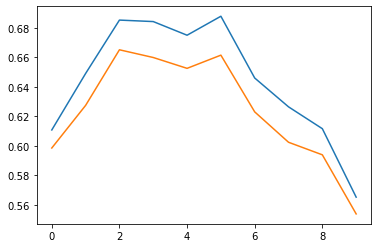

In [182]:
plt.plot(auc)
plt.plot(auc63)

In [187]:
## top features
# print(best_feat[1][:5])
# print(best_feat[2][:5])
# print(best_feat[3][:5])
# print(best_feat[4][:5])
# print(best_feat[5][:5])
# print(best_feat[6][:5])
# print(best_feat[7][:5])

best_feat63[3][:5]


## 3 is it. (given motor invovelent and high accuracy)

['WM Acoustic radiation',
 'GM Primary motor cortex BA4p',
 'GM Visual cortex V1 BA17',
 'GM Inferior parietal lobule PFm',
 'WM Uncinate fascicle']

In [1323]:
## Conclusion - 3/4 images post cue is the right time! 
#for the full label, 1 for the short one

In [259]:
### NOW ACTUALLY LET'S TRY

In [ ]:
## decode additioanl draw info

In [34]:
## prep df

all_behav_data['additional_draw_T'] = 0 # time for additional draws
all_behav_data['additional_draw_N_high'] = 0 # nunber of additional high draws
all_behav_data['additional_draw_N_low'] = 0 # nunber of additional low draws


tmp_all_behav_data = all_behav_data[all_behav_data.event_type.isin([#'initial_beads',
                                                #'extra_bead',
                                        'additional_draw_allowed',
                                               'terminate_draw',
                                              ])][['onset',
                                                  'event_type',
                                                 'num_beads_high',
                                                 'num_beads_low']]

In [35]:
### add additioanl draw info to df
for (i0, row0), (i1, row1) in zip(tmp_all_behav_data[:-1].iterrows(),
                    tmp_all_behav_data[1:].iterrows()):

    
    if (row0.event_type=='additional_draw_allowed') &\
             (row1.event_type=='terminate_draw'):
        delta_t = row1.onset - row0.onset
        additional_draw_N_high = row1.num_beads_high - row0.num_beads_high
        additional_draw_N_low = row1.num_beads_low - row0.num_beads_low

        all_behav_data.loc[i0,['additional_draw_T']] = delta_t
        all_behav_data.loc[i0,['additional_draw_N_high']] = additional_draw_N_high
        all_behav_data.loc[i0,['additional_draw_N_low']] = additional_draw_N_low

  

In [189]:
## prep data additioanl draw time (AD_T)

data_x_AD = [] # AD X 
data_x63_AD = [] # AD X 

data_y_AD_T = [] # AD RT
data_y_AD_NH = [] #AD num of high
data_y_AD_NL = [] #AD num of low
data_y_AD_cur_N = [] #AD cur total
data_y_AD_cur_dif_N = [] #AD cur diff




for sub_i, sub in tqdm(enumerate(nifti_data_paths)):
    for run in nifti_data_paths[sub]:
        
        sub_run_df = all_behav_data[(all_behav_data['subject']==sub) &\
               (all_behav_data['run']==run) &\
              (all_behav_data['clean_data']==True) &\
            (all_behav_data['event_type']=='additional_draw_allowed')                    ]
        
        sub_run_times = sub_run_df.onset.to_list()
        sub_run_ADT_y = sub_run_df.additional_draw_T.to_list()
        sub_run_ADNH_y = sub_run_df.additional_draw_N_high.to_list()
        sub_run_ADNL_y = sub_run_df.additional_draw_N_low.to_list()
        sub_run_AD_curr_N_y = (sub_run_df.num_beads_high + sub_run_df.num_beads_low).to_list()
        sub_run_AD_curr_diff_N_y =  np.abs(sub_run_df.num_beads_high - sub_run_df.num_beads_low).to_list()
        if len(sub_run_times) == 0:
            continue

        for time_i, time in enumerate(sub_run_times[:-4]):
            img_index = max(int(time/TR)-1,0) # 3 TR ~4.5 sec seems to be right timing
            
            data = all_time_series[sub_i, run-1, img_index+3:img_index+6]
            data63 = all_time_series[sub_i, run-1, img_index+2:img_index+5, :63]
            
            if data.shape == (3,101):
                data_x_AD.append(data) # 31, 32 is motor cortex
            if data63.shape == (3,63):
                data_x63_AD.append(data63)
                
            data_y_AD_T.append(sub_run_ADT_y[time_i])
            data_y_AD_NH.append(sub_run_ADNH_y[time_i])
            data_y_AD_NL.append(sub_run_ADNL_y[time_i])
            data_y_AD_cur_N.append(sub_run_AD_curr_N_y[time_i])
            data_y_AD_cur_dif_N.append(sub_run_AD_curr_diff_N_y[time_i])
            

15it [00:00, 50.52it/s]


In [190]:
data_x_AD_arr = np.array(data_x_AD)
data_x63_AD_arr = np.array(data_x63_AD)
data_y_AD_T_arr = np.array(data_y_AD_T)
data_y_AD_NH_arr = np.array(data_y_AD_NH)
data_y_AD_NL_arr = np.array(data_y_AD_NL)

data_y_AD_cur_N_arr = np.array(data_y_AD_cur_N)
data_y_AD_cur_diff_N_arr = np.array(data_y_AD_cur_dif_N)



In [191]:
data_y_AD_N_arr = data_y_AD_NH_arr + data_y_AD_NL_arr #total extra draw
data_y_AD_rel_N_arr = data_y_AD_N_arr / (data_y_AD_N_arr + data_y_AD_cur_N_arr) #realtive to totla
data_y_AD_rel_dif_N_arr = data_y_AD_N_arr / data_y_AD_cur_diff_N_arr #realtive to diff

data_y_AD_T_div_N_arr = data_y_AD_T_arr/(data_y_AD_N_arr+1)

# time to draw/n of draws
y_T_norm = data_y_AD_T_arr/(data_y_AD_N_arr+1)

# diff in categories / total beads
y_curr_uncer = np.abs(data_y_AD_cur_diff_N_arr)/(data_y_AD_cur_N_arr)



In [1059]:
# regr = svm.SVR(kernel='linear')
# r2s=[]   
# for t in range(3):
#     norm_data_x_AD_T_arr = Normalizer().fit_transform(data_x_AD_T_arr[:,t,:])

#     X_ADT_train, X_ADT_test, y_ADT_train, y_ADT_test =\
#     train_test_split(norm_data_x_AD_T_arr, 
#                                 data_y_AD_T_arr, 
#                                 test_size=0.5, 
#                                 random_state=0)

#     regr.fit(X_ADT_train, y_ADT_train)
#     y_hat = regr.predict(X_ADT_test)
#     r2s.append(r2_score(y_ADT_test, y_hat))

In [1060]:
#reg.coef_

#r2_score(y_ADT_test, y_hat)
# mean_squared_error(y_ADT_test, y_hat)

In [62]:
import statsmodels.api as sm
from statsmodels.stats.mediation import Mediation

In [159]:
################ beavhrioal #############
####### REF 1###


model_med = sm.OLS(data_y_AD_cur_dif_N/(data_y_AD_cur_N_arr+1), 
                          data_y_AD_T_arr/(data_y_AD_N_arr+1), 
                   hasconst=False)
res_model_med = model_med.fit()
res_model_med.summary()

# model_med1 = sm.OLS(data_y_AD_cur_dif_N/(data_y_AD_cur_N_arr+1), 
#                           data_y_AD_N_arr,
#                     hasconst=False)

# res_model_med1 = model_med1.fit()
# res_model_med1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.636
Model:                            OLS   Adj. R-squared (uncentered):              0.636
Method:                 Least Squares   F-statistic:                              1930.
Date:                Fri, 29 Apr 2022   Prob (F-statistic):                   1.28e-244
Time:                        14:33:05   Log-Likelihood:                          484.11
No. Observations:                1105   AIC:                                     -966.2
Df Residuals:                    1104   BIC:                                     -961.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2358      0.005     43.934      0.000       0.225       0.246
==============================================================================
Omnibus:                       26.460   Durbin-Watson:                   1.683
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               15.009
Skew:                           0.098   Prob(JB):                     0.000550
Kurtosis:                       2.464   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [192]:
# x_AD_norm0 = Normalizer().fit_transform(data_x_AD_arr[:,0,:])
# x_AD_norm0_df = pd.DataFrame(x_AD_norm0, 
#              columns=all_lables)

x63_AD_norm0 = Normalizer().fit_transform(data_x63_AD_arr[:,1,:])

x63_AD_norm0_df = pd.DataFrame(x63_AD_norm0, 
             columns=dataset_ju_object.labels)

In [193]:
# x_AD_norm0_df['Norm Curr N diff'] = data_y_AD_cur_dif_N/data_y_AD_cur_N_arr
# x_AD_norm0_df['Norm AD T'] = data_y_AD_T_arr/data_y_AD_N_arr


x63_AD_norm0_df['Norm_Curr_N_diff'] = data_y_AD_cur_dif_N/(data_y_AD_cur_N_arr+1)
x63_AD_norm0_df['Norm_AD_T'] = data_y_AD_T_arr/(data_y_AD_N_arr+1)


In [194]:
# x_AD_norm0_df.columns = x_AD_norm0_df.columns.str.replace(' ','_') 
# x_AD_norm0_df.columns = x_AD_norm0_df.columns.str.replace('.','_')
# x_AD_norm0_df.columns = x_AD_norm0_df.columns.str.replace("'",'_')
# x_AD_norm0_df.columns = x_AD_norm0_df.columns.str.replace("-",'_')
# x_AD_norm0_df.columns = x_AD_norm0_df.columns.str.replace("/",'')


x63_AD_norm0_df.columns = x63_AD_norm0_df.columns.str.replace(' ','_') 
x63_AD_norm0_df.columns = x63_AD_norm0_df.columns.str.replace('.','_')
x63_AD_norm0_df.columns = x63_AD_norm0_df.columns.str.replace("'",'_')
x63_AD_norm0_df.columns = x63_AD_norm0_df.columns.str.replace("-",'_')
x63_AD_norm0_df.columns = x63_AD_norm0_df.columns.str.replace("/",'')
#all_rois = 
#outcome_m_str = ' + '.join(['Norm_AD_T ~ Norm_Curr_N_diff',' + '.join(x_AD_norm0_df.columns[:-2])])
#med_m_str = 'GM_Hippocampus_dentate_gyrus ~ Norm_Curr_N_diff'

outcome_m_str = ' + '.join(['Norm_AD_T ~ Norm_Curr_N_diff', ' + '.join(x63_AD_norm0_df.columns[:-2])])
med_m_str = 'GM_Hippocampus_dentate_gyrus ~ Norm_Curr_N_diff'


In [195]:
#x63_AD_norm0_df.columns

In [196]:
#x_AD_norm0_df.dropna(inplace=True)
x63_AD_norm0_df.dropna(inplace=True)

In [197]:
#### norm current diff in n ~ norm time to draw
# model_cursm.OLS(data_y_AD_cur_dif_N/data_y_AD_cur_N_arr,
#        data_y_AD_T_arr/(data_y_AD_N_arr+1)).fit()

outcome_model = sm.GLM.from_formula(
        outcome_m_str,
    data=x63_AD_norm0_df)

mediator_model = sm.GLM.from_formula(med_m_str,
                                     data=x63_AD_norm0_df)


med = Mediation(
        outcome_model,
        mediator_model,
        "Norm_Curr_N_diff",
        "GM_Hippocampus_dentate_gyrus",
    )



In [198]:
med_result = med.fit(n_rep=20)


In [199]:
med_result.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),-0.000382,-0.005529,0.004936,1.0
ACME (treated),-0.000382,-0.005529,0.004936,1.0
ADE (control),0.302879,0.153145,0.421813,0.0
ADE (treated),0.302879,0.153145,0.421813,0.0
Total effect,0.302497,0.148741,0.421475,0.0
Prop. mediated (control),-0.000279,-0.030819,0.014611,1.0
Prop. mediated (treated),-0.000279,-0.030819,0.014611,1.0
ACME (average),-0.000382,-0.005529,0.004936,1.0
ADE (average),0.302879,0.153145,0.421813,0.0
Prop. mediated (average),-0.000279,-0.030819,0.014611,1.0


In [200]:
#y_T_norm.,y_curr_uncer

model_AD_CUR_UNCER63 = sm.OLS(y_curr_uncer, 
                           sm.add_constant(pd.DataFrame(x63_AD_norm0, 
             columns=dataset_ju_object.labels)))

res_model_AD_CUR_UNCER63 = model_AD_CUR_UNCER63.fit()
res_model_AD_CUR_UNCER63.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.148
Date:                Fri, 29 Apr 2022   Prob (F-statistic):              0.206
Time:                        14:56:18   Log-Likelihood:                 612.05
No. Observations:                1105   AIC:                            -1096.
Df Residuals:                    1041   BIC:                            -775.6
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                          0.2315      0.005     44.366      0.000       0.221       0.242
Background                                                     0.0473      0.050      0.949      0.343      -0.051       0.145
GM Amygdala_centromedial group                                 0.0283      0.056      0.502      0.616      -0.082       0.139
GM Amygdala_laterobasal group                                  0.0328      0.050      0.661      0.509      -0.064       0.130
GM Amygdala_superficial group                                  0.0654      0.062      1.050      0.294      -0.057       0.188
GM Anterior intra-parietal sulcus hIP1                         0.0093      0.053      0.177      0.860      -0.094       0.113
GM Anterior intra-parietal sulcus hIP2                         0.1609      0.061      2.652      0.008       0.042       0.280
GM Anterior intra-parietal sulcus hIP3                         0.1830      0.066      2.765      0.006       0.053       0.313
GM Broca's area BA44                                           0.0259      0.053      0.486      0.627      -0.079       0.131
GM Broca's area BA45                                           0.0189      0.077      0.247      0.805      -0.131       0.169
GM Hippocampus cornu ammonis                                   0.0429      0.059      0.726      0.468      -0.073       0.159
GM Hippocampus dentate gyrus                                  -0.0242      0.046     -0.530      0.596      -0.114       0.065
GM Hippocampus entorhinal cortex                               0.0552      0.045      1.222      0.222      -0.033       0.144
GM Hippocampus hippocampal-amygdaloid transition area          0.1010      0.058      1.744      0.081      -0.013       0.215
GM Hippocampus subiculum                                      -0.0379      0.061     -0.618      0.537      -0.158       0.082
GM Inferior parietal lobule PF                                -0.0470      0.066     -0.716      0.474      -0.176       0.082
GM Inferior parietal lobule PFcm                              -0.0236      0.053     -0.449      0.653      -0.127       0.079
GM Inferior parietal lobule PFm                               -0.0197      0.052     -0.380      0.704      -0.121       0.082
GM Inferior parietal lobule PFop                              -0.1130      0.059     -1.924      0.055      -0.228       0.002
GM Inferior parietal lobule PFt                               -0.0749      0.055     -1.371      0.171      -0.182       0.032
GM Inferior parietal lobule PGp                               -0.1032      0.071     -1.458      0.145      -0.242       0.036
GM Inferior parietal lobule Pga    

In [203]:
#y_T_norm.,y_curr_uncer

model_AD_CUR_N_div_UNCER63 = sm.OLS(data_y_AD_N_arr/y_curr_uncer, 
                           sm.add_constant(pd.DataFrame(x63_AD_norm0, 
             columns=dataset_ju_object.labels)))

res_model_AD_CUR_N_div_UNCER63 = model_AD_CUR_N_div_UNCER63.fit()
res_model_AD_CUR_N_div_UNCER63.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     1.651
Date:                Fri, 29 Apr 2022   Prob (F-statistic):            0.00136
Time:                        15:06:31   Log-Likelihood:                -5350.0
No. Observations:                1105   AIC:                         1.083e+04
Df Residuals:                    1041   BIC:                         1.115e+04
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                          7.9461      1.150      6.909      0.000       5.689      10.203
Background                                                    17.3973     10.993      1.583      0.114      -4.174      38.969
GM Amygdala_centromedial group                               -15.4636     12.432     -1.244      0.214     -39.859       8.932
GM Amygdala_laterobasal group                                 -7.7183     10.922     -0.707      0.480     -29.150      13.714
GM Amygdala_superficial group                                 -5.8077     13.728     -0.423      0.672     -32.746      21.130
GM Anterior intra-parietal sulcus hIP1                       -18.8082     11.641     -1.616      0.106     -41.650       4.033
GM Anterior intra-parietal sulcus hIP2                       -27.6633     13.375     -2.068      0.039     -53.907      -1.419
GM Anterior intra-parietal sulcus hIP3                        -2.7877     14.585     -0.191      0.848     -31.407      25.832
GM Broca's area BA44                                         -18.5183     11.759     -1.575      0.116     -41.592       4.556
GM Broca's area BA45                                          -3.4328     16.864     -0.204      0.839     -36.524      29.659
GM Hippocampus cornu ammonis                                 -23.2086     13.019     -1.783      0.075     -48.756       2.338
GM Hippocampus dentate gyrus                                  -6.5418     10.072     -0.650      0.516     -26.305      13.222
GM Hippocampus entorhinal cortex                              -3.0810      9.964     -0.309      0.757     -22.632      16.470
GM Hippocampus hippocampal-amygdaloid transition area        -12.0078     12.765     -0.941      0.347     -37.055      13.039
GM Hippocampus subiculum                                       3.9909     13.522      0.295      0.768     -22.543      30.524
GM Inferior parietal lobule PF                                11.2561     14.465      0.778      0.437     -17.128      39.641
GM Inferior parietal lobule PFcm                             -15.0592     11.575     -1.301      0.194     -37.772       7.653
GM Inferior parietal lobule PFm                               15.2741     11.429      1.336      0.182      -7.153      37.701
GM Inferior parietal lobule PFop                               0.9774     12.946      0.075      0.940     -24.425      26.380
GM Inferior parietal lobule PFt                               -6.1511     12.036     -0.511      0.609     -29.769      17.467
GM Inferior parietal lobule PGp                              -22.5304     15.605     -1.444      0.149     -53.152       8.091
GM Inferior parietal lobule Pga    

In [227]:
#res_model_AD_CUR_N_div_UNCER63.summary().tables[1].as_csv()
ADN_UNCERT63_df = pd.read_csv('results_OLS_ADN_UNCERT63.csv', sep=',')
ADN_UNCERT63_df['abs_t'] = ADN_UNCERT63_df.t.abs()
ADN_UNCERT63_df.sort_values(by=['abs_t'], ascending=False)[:10]


,coef,std err,t,P>|t|,[0.025,0.975],abs_t
const,7.9461,1.150,6.909,0.000,5.689,10.203,6.909
WM Superior occipito-frontal fascicle,-36.7107,10.504,-3.495,0.000,-57.322,-16.099,3.495
WM Cingulum,41.4016,14.427,2.870,0.004,13.092,69.711,2.870
WM Fornix,23.2213,11.003,2.110,0.035,1.631,44.812,2.110
GM Anterior intra-parietal sulcus hIP2,-27.6633,13.375,-2.068,0.039,-53.907,-1.419,2.068
WM Corticospinal tract,-27.5357,13.902,-1.981,0.048,-54.815,-0.256,1.981
GM Mamillary body,-21.3658,11.518,-1.855,0.064,-43.967,1.235,1.855
WM Superior longitudinal fascicle,-22.5672,12.328,-1.830,0.067,-46.759,1.624,1.830
GM Hippocampus cornu ammonis,-23.2086,13.019,-1.783,0.075,-48.756,2.338,1.783
GM Superior parietal lobule 7M,18.5584,11.441,1.622,0.105,-3.892,41.009,1.622


In [201]:
model_ADN63 = sm.OLS(data_y_AD_N_arr, 
                           sm.add_constant(pd.DataFrame(x63_AD_norm0, 
             columns=dataset_ju_object.labels)))
res_model_ADN63 = model_ADN63.fit()
res_model_ADN63.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     2.251
Date:                Fri, 29 Apr 2022   Prob (F-statistic):           2.22e-07
Time:                        14:56:36   Log-Likelihood:                -2497.1
No. Observations:                1105   AIC:                             5122.
Df Residuals:                    1041   BIC:                             5443.
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                          0.8551      0.087      9.830      0.000       0.684       1.026
Background                                                     1.5447      0.832      1.858      0.064      -0.087       3.176
GM Amygdala_centromedial group                                -1.0610      0.940     -1.128      0.259      -2.906       0.784
GM Amygdala_laterobasal group                                 -0.6844      0.826     -0.828      0.408      -2.306       0.937
GM Amygdala_superficial group                                 -2.1476      1.038     -2.068      0.039      -4.185      -0.110
GM Anterior intra-parietal sulcus hIP1                        -2.5199      0.880     -2.862      0.004      -4.248      -0.792
GM Anterior intra-parietal sulcus hIP2                        -1.0229      1.012     -1.011      0.312      -3.008       0.962
GM Anterior intra-parietal sulcus hIP3                         0.5025      1.103      0.455      0.649      -1.662       2.667
GM Broca's area BA44                                          -1.6981      0.889     -1.909      0.057      -3.443       0.047
GM Broca's area BA45                                          -0.7279      1.276     -0.571      0.568      -3.231       1.775
GM Hippocampus cornu ammonis                                  -0.6925      0.985     -0.703      0.482      -2.625       1.240
GM Hippocampus dentate gyrus                                  -0.2352      0.762     -0.309      0.758      -1.730       1.260
GM Hippocampus entorhinal cortex                              -0.2344      0.754     -0.311      0.756      -1.713       1.244
GM Hippocampus hippocampal-amygdaloid transition area          0.3040      0.966      0.315      0.753      -1.591       2.199
GM Hippocampus subiculum                                       0.3070      1.023      0.300      0.764      -1.700       2.314
GM Inferior parietal lobule PF                                 2.0835      1.094      1.904      0.057      -0.064       4.231
GM Inferior parietal lobule PFcm                              -1.1058      0.876     -1.263      0.207      -2.824       0.612
GM Inferior parietal lobule PFm                                0.2617      0.865      0.303      0.762      -1.435       1.958
GM Inferior parietal lobule PFop                               1.1750      0.979      1.200      0.230      -0.746       3.097
GM Inferior parietal lobule PFt                               -0.6844      0.910     -0.752      0.452      -2.471       1.102
GM Inferior parietal lobule PGp                               -2.3734      1.180     -2.011      0.045      -4.690      -0.057
GM Inferior parietal lobule Pga    

In [224]:
#res_model_ADN63.summary().tables[1].as_csv()
ADN63_df = pd.read_csv('results_OLS_ADN63.csv', sep=',')
ADN63_df['abs_t'] = ADN63_df.t.abs()
ADN63_df.sort_values(by=['abs_t'], ascending=False)[:10]


,coef,std err,t,P>|t|,[0.025,0.975],abs_t
const,0.8551,0.087,9.830,0.000,0.684,1.026,9.830
GM Anterior intra-parietal sulcus hIP1,-2.5199,0.880,-2.862,0.004,-4.248,-0.792,2.862
WM Superior occipito-frontal fascicle,-2.2609,0.795,-2.846,0.005,-3.820,-0.702,2.846
GM Superior parietal lobule 7PC,2.6146,0.930,2.813,0.005,0.791,4.439,2.813
GM Superior parietal lobule 5M,2.6232,0.971,2.701,0.007,0.717,4.529,2.701
GM Secondary somatosensory cortex / Parietal operculum OP1,2.3184,0.866,2.679,0.008,0.620,4.017,2.679
GM Primary somatosensory cortex BA3b,2.2585,0.867,2.604,0.009,0.557,3.960,2.604
GM Premotor cortex BA6,-1.9246,0.818,-2.354,0.019,-3.529,-0.320,2.354
WM Fornix,1.7729,0.832,2.130,0.033,0.140,3.406,2.130
GM Amygdala_superficial group,-2.1476,1.038,-2.068,0.039,-4.185,-0.110,2.068


In [202]:
model_ADT_div_N63 = sm.OLS(data_y_AD_T_div_N_arr, 
                           sm.add_constant(pd.DataFrame(x63_AD_norm0, 
             columns=dataset_ju_object.labels)))
res_model_ADT_div_N63 = model_ADT_div_N63.fit()
res_model_ADT_div_N63.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     1.904
Date:                Fri, 29 Apr 2022   Prob (F-statistic):           4.45e-05
Time:                        14:56:40   Log-Likelihood:                -375.56
No. Observations:                1105   AIC:                             879.1
Df Residuals:                    1041   BIC:                             1200.
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                          0.7795      0.013     61.120      0.000       0.755       0.805
Background                                                     0.1662      0.122      1.364      0.173      -0.073       0.405
GM Amygdala_centromedial group                                 0.0588      0.138      0.426      0.670      -0.212       0.329
GM Amygdala_laterobasal group                                 -0.0910      0.121     -0.751      0.453      -0.329       0.147
GM Amygdala_superficial group                                  0.1852      0.152      1.217      0.224      -0.113       0.484
GM Anterior intra-parietal sulcus hIP1                         0.0501      0.129      0.388      0.698      -0.203       0.303
GM Anterior intra-parietal sulcus hIP2                         0.3185      0.148      2.147      0.032       0.027       0.610
GM Anterior intra-parietal sulcus hIP3                        -0.4807      0.162     -2.972      0.003      -0.798      -0.163
GM Broca's area BA44                                           0.0278      0.130      0.213      0.831      -0.228       0.284
GM Broca's area BA45                                          -0.3702      0.187     -1.980      0.048      -0.737      -0.003
GM Hippocampus cornu ammonis                                   0.0267      0.144      0.185      0.853      -0.257       0.310
GM Hippocampus dentate gyrus                                   0.0435      0.112      0.390      0.697      -0.176       0.263
GM Hippocampus entorhinal cortex                              -0.1105      0.110     -1.000      0.318      -0.327       0.106
GM Hippocampus hippocampal-amygdaloid transition area         -0.1155      0.142     -0.816      0.415      -0.393       0.162
GM Hippocampus subiculum                                       0.2827      0.150      1.885      0.060      -0.012       0.577
GM Inferior parietal lobule PF                                -0.3492      0.160     -2.177      0.030      -0.664      -0.034
GM Inferior parietal lobule PFcm                              -0.0360      0.128     -0.281      0.779      -0.288       0.216
GM Inferior parietal lobule PFm                               -0.1759      0.127     -1.388      0.165      -0.425       0.073
GM Inferior parietal lobule PFop                               0.0802      0.144      0.559      0.577      -0.202       0.362
GM Inferior parietal lobule PFt                                0.0546      0.133      0.409      0.683      -0.207       0.316
GM Inferior parietal lobule PGp                                0.0069      0.173      0.040      0.968      -0.333       0.347
GM Inferior parietal lobule Pga    

In [222]:
#res_model_ADT_div_N63.summary().tables[1].as_csv()
ADT_div_N63_df = pd.read_csv('results_OLS_ADT_div_N63.csv', sep=',')
ADT_div_N63_df['abs_t'] = ADT_div_N63_df.t.abs()
ADT_div_N63_df.sort_values(by=['abs_t'], ascending=False)[:10]


,coef,std err,t,P>|t|,[0.025,0.975],abs_t
const,0.7795,0.013,61.120,0.000,0.755,0.805,61.120
GM Superior parietal lobule 7PC,-0.4817,0.136,-3.535,0.000,-0.749,-0.214,3.535
GM Anterior intra-parietal sulcus hIP3,-0.4807,0.162,-2.972,0.003,-0.798,-0.163,2.972
GM Primary auditory cortex TE1.1,0.3146,0.115,2.727,0.006,0.088,0.541,2.727
GM Inferior parietal lobule PF,-0.3492,0.160,-2.177,0.030,-0.664,-0.034,2.177
GM Anterior intra-parietal sulcus hIP2,0.3185,0.148,2.147,0.032,0.027,0.610,2.147
GM Broca's area BA45,-0.3702,0.187,-1.980,0.048,-0.737,-0.003,1.980
GM Hippocampus subiculum,0.2827,0.150,1.885,0.060,-0.012,0.577,1.885
WM Inferior occipito-frontal fascicle,-0.3402,0.183,-1.863,0.063,-0.699,0.018,1.863
WM Fornix,-0.2234,0.122,-1.831,0.067,-0.463,0.016,1.831


In [1217]:
### represtation of current info (diff/N) - normed
#model_cur_beads_stat = sm.OLS(data_y_AD_cur_dif_N/data_y_AD_cur_N_arr , x_AD_norm0_df)
#res_cur_beads_stat = model_cur_beads_stat.fit()

#res_cur_beads_stat.summary().tables[1].as_csv()
OLS_cur_beads_stat_df = pd.read_csv('results_OLS_AD_curr_bead_stats.csv', sep=',')
OLS_cur_beads_stat_df['abs_t'] = OLS_cur_beads_stat_df.t.abs()


OLS_cur_beads_stat_df.sort_values(by=['abs_t'], ascending=False)[:15]


,coef,std err,t,P>|t|,[0.025,0.975],abs_t
GM Primary motor cortex BA4a,0.8957,0.235,3.812,0.000,0.435,1.357,3.812
Motor,-1.7089,0.451,-3.793,0.000,-2.593,-0.825,3.793
GM Premotor cortex BA6,1.0570,0.280,3.769,0.000,0.507,1.607,3.769
GM Superior parietal lobule 7A,-0.7085,0.223,-3.182,0.002,-1.145,-0.272,3.182
L Aud,-0.6604,0.212,-3.108,0.002,-1.077,-0.243,3.108
GM Superior parietal lobule 7P,-0.3963,0.139,-2.861,0.004,-0.668,-0.125,2.861
L LOC,-0.4099,0.166,-2.475,0.013,-0.735,-0.085,2.475
WM Cingulum,-0.4187,0.170,-2.459,0.014,-0.753,-0.085,2.459
R TPJ,-0.4015,0.173,-2.323,0.020,-0.741,-0.062,2.323
GM Primary motor cortex BA4p,0.3975,0.175,2.277,0.023,0.055,0.740,2.277


In [1071]:
model_ADT = sm.OLS(data_y_AD_T_arr, x_AD_norm0_df)
model_ADN = sm.OLS(data_y_AD_N_arr, x_AD_norm0_df)
model_ADN_rel = sm.OLS(data_y_AD_rel_N_arr, x_AD_norm0_df)
model_ADN_dif = sm.OLS(data_y_AD_rel_dif_N_arr, x_AD_norm0_df)

model_ADT_div_N = sm.OLS(data_y_AD_T_div_N_arr, x_AD_norm0_df)



res_ADT = model_ADT.fit()
res_ADN = model_ADN.fit()
res_ADT_rel = model_ADN_rel.fit()
res_ADN_dif = model_ADN_dif.fit()

res_model_ADT_div_N = model_ADT_div_N.fit()


# check ig RT <> num draws // normalize
# causal triangle model
# mutual predciteior 

In [1072]:
# dir(res0)
#res_ADT_div_N_dif.summary().tables[1].as_csv()

In [1073]:
res_ADT_div_N_dif.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.301
Model:                            OLS   Adj. R-squared (uncentered):              0.230
Method:                 Least Squares   F-statistic:                              4.271
Date:                Thu, 28 Apr 2022   Prob (F-statistic):                    2.79e-33
Time:                        12:18:50   Log-Likelihood:                         -1223.6
No. Observations:                1105   AIC:                                      2649.
Df Residuals:                    1004   BIC:                                      3155.
Df Model:                         101                                                  
Covariance Type:            nonrobust                                                  
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
GM Amygdala_centromedial group                                -0.2390      0.358     -0.667      0.505      -0.942       0.464
GM Amygdala_laterobasal group                                 -0.4629      0.398     -1.164      0.245      -1.243       0.317
GM Amygdala_superficial group                                 -0.6402      0.357     -1.792      0.073      -1.341       0.061
GM Anterior intra-parietal sulcus hIP1                        -2.1869      0.770     -2.841      0.005      -3.697      -0.676
GM Anterior intra-parietal sulcus hIP2                        -1.8680      0.766     -2.438      0.015      -3.372      -0.364
GM Anterior intra-parietal sulcus hIP3                        -2.0903      0.816     -2.561      0.011      -3.692      -0.489
GM Broca's area BA44                                           0.1229      0.614      0.200      0.841      -1.082       1.328
GM Broca's area BA45                                          -0.4011      0.662     -0.606      0.544      -1.699       0.897
GM Hippocampus cornu ammonis                                  -0.3433      0.526     -0.653      0.514      -1.376       0.689
GM Hippocampus dentate gyrus                                   0.3253      0.397      0.819      0.413      -0.455       1.105
GM Hippocampus entorhinal cortex                              -0.1192      0.357     -0.334      0.739      -0.821       0.582
GM Hippocampus hippocampal-amygdaloid transition area         -0.1697      0.321     -0.529      0.597      -0.799       0.460
GM Hippocampus subiculum                                      -0.7630      0.425     -1.794      0.073      -1.598       0.072
GM Inferior parietal lobule PF                                -0.2584      0.560     -0.461      0.645      -1.358       0.841
GM Inferior parietal lobule PFcm                              -0.2493      0.596     -0.418      0.676      -1.418       0.920
GM Inferior parietal lobule PFm                               -0.1391      0.526     -0.265      0.791      -1.171       0.892
GM Inferior parietal lobule PFop                               0.3990      0.476      0.839      0.402      -0.534       1.332
GM Inferior parietal lobule PFt                               -1.1406      0.976     -1.169      0.243      -3.056       0.774
GM Inferior parietal lobule PGp                                0.7547      0.448      1.683      0.093      -0.125       1.635
GM Inferior parietal lobule Pga                                1.2566      0.789      1.593      0.112      -0.292       2.805
GM Insula Id1                                                 -

In [1047]:

OLS_ADT_df = pd.read_csv('results_OLS_ADT.csv', sep=',')
OLS_ADT_df.columns = ['coef', 'std err', 't', 'P>|t|', '[0.025','0.975]']

OLS_ADT_df['abs_t'] = OLS_ADT_df.t.abs()
OLS_ADT_df.head()


,coef,std err,t,P>|t|,[0.025,0.975],abs_t
GM Amygdala_centromedial group,0.3007,0.627,0.480,0.631,-0.929,1.530,0.480
GM Amygdala_laterobasal group,0.1559,0.696,0.224,0.823,-1.209,1.521,0.224
GM Amygdala_superficial group,-0.5677,0.625,-0.908,0.364,-1.794,0.659,0.908
GM Anterior intra-parietal sulcus hIP1,-2.4765,1.347,-1.838,0.066,-5.120,0.167,1.838
GM Anterior intra-parietal sulcus hIP2,-2.8552,1.341,-2.129,0.033,-5.486,-0.224,2.129


In [727]:
OLS_ADT_df.sort_values(by=['abs_t'], ascending=False)[:15]
#WEIRD results....

,coef,std err,t,P>|t|,[0.025,0.975],abs_t
GM Premotor cortex BA6,6.3820,1.560,4.090,0.000,3.320,9.444,4.090
GM Hippocampus subiculum,-2.8315,0.744,-3.804,0.000,-4.292,-1.371,3.804
GM Primary motor cortex BA4a,4.8948,1.307,3.744,0.000,2.329,7.460,3.744
L Aud,-3.7989,1.182,-3.213,0.001,-6.119,-1.479,3.213
Motor,-7.1965,2.507,-2.871,0.004,-12.116,-2.277,2.871
WM Corticospinal tract,2.8319,0.987,2.869,0.004,0.895,4.769,2.869
L IPS,3.2523,1.379,2.358,0.019,0.545,5.959,2.358
L LOC,-2.1534,0.921,-2.337,0.020,-3.962,-0.345,2.337
GM Superior parietal lobule 7A,-2.8750,1.239,-2.320,0.021,-5.306,-0.444,2.320
Sup Front S,-1.6307,0.732,-2.227,0.026,-3.068,-0.194,2.227


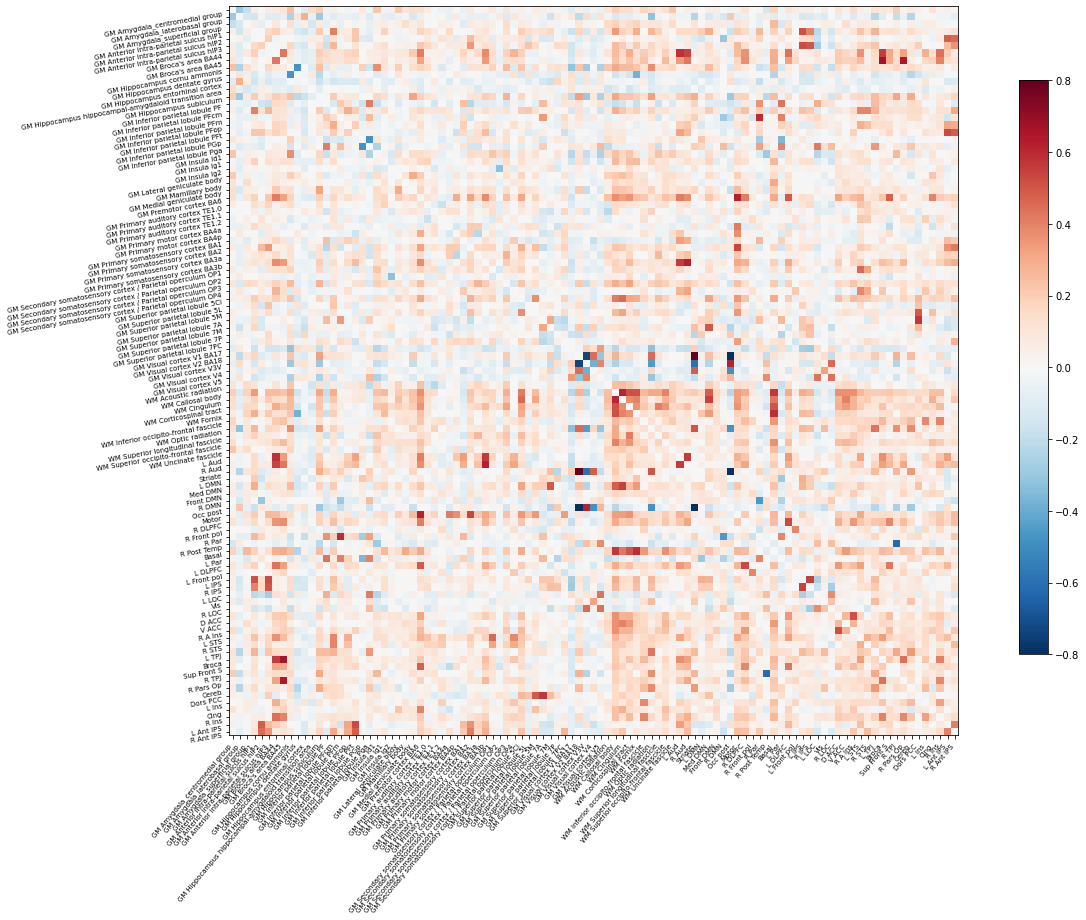

In [817]:
#plt.imshow(np.corrcoef(x_norm0.T))

from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([x_norm0])[0]
fig,ax = plt.subplots(figsize=(15,15))
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, labels=all_lables, colorbar=True,
                     vmax=0.8, vmin=-0.8, figure=fig)

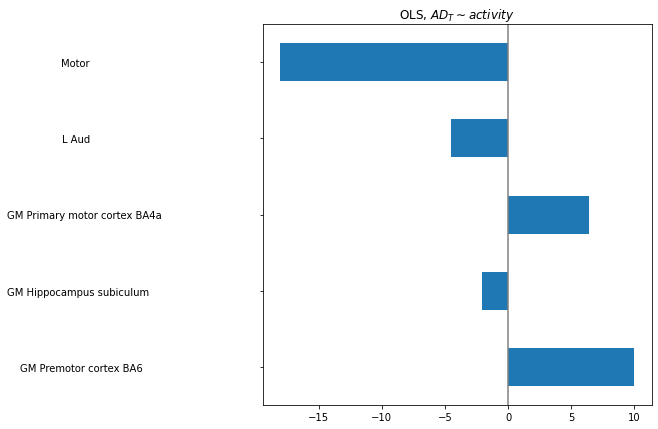

In [887]:
OLS_ADT_df_top_5 = OLS_ADT_df.sort_values(by=['abs_t'], ascending=False)[:5]
# sns.boxplot(x="t", y=OLS_ADN_dif_df_top_15.index, 
#             data=OLS_ADN_dif_df_top_15,
#             whis=[0, 100], width=.6, palette="vlag")


(OLS_ADT_df_top_5['coef']*OLS_ADT_df_top_5['std err']).\
            plot(kind="barh", figsize=(9, 7))

plt.title(r"OLS, $AD_T \sim activity$")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)
plt.show()

## FASTER MEANS HIGHER MOTOR. MAKES SENSE? 
# BUT ALSO FASTER MEANS HIPO?

In [843]:
OLS_ADT_div_N_df = pd.read_csv('results_OLS_ADT_div_N.csv', sep=',')
OLS_ADT_div_N_df.head()

OLS_ADT_div_N_df['abs_t'] = OLS_ADT_div_N_df.t.abs()
OLS_ADT_div_N_df.head()


,coef,std err,t,P>|t|,[0.025,0.975],abs_t
GM Amygdala_centromedial group,-0.2390,0.358,-0.667,0.505,-0.942,0.464,0.667
GM Amygdala_laterobasal group,-0.4629,0.398,-1.164,0.245,-1.243,0.317,1.164
GM Amygdala_superficial group,-0.6402,0.357,-1.792,0.073,-1.341,0.061,1.792
GM Anterior intra-parietal sulcus hIP1,-2.1869,0.770,-2.841,0.005,-3.697,-0.676,2.841
GM Anterior intra-parietal sulcus hIP2,-1.8680,0.766,-2.438,0.015,-3.372,-0.364,2.438


In [844]:
OLS_ADT_div_N_df.sort_values(by=['abs_t'], ascending=False)[:15]


,coef,std err,t,P>|t|,[0.025,0.975],abs_t
GM Superior parietal lobule 7A,-2.9784,0.708,-4.206,0.000,-4.368,-1.589,4.206
L LOC,-2.0491,0.527,-3.891,0.000,-3.083,-1.016,3.891
R DLPFC,1.4518,0.442,3.283,0.001,0.584,2.320,3.283
L IPS,2.5476,0.788,3.232,0.001,1.001,4.095,3.232
GM Primary motor cortex BA4a,2.3578,0.747,3.156,0.002,0.892,3.824,3.156
Motor,-4.2688,1.433,-2.979,0.003,-7.080,-1.457,2.979
GM Anterior intra-parietal sulcus hIP1,-2.1869,0.770,-2.841,0.005,-3.697,-0.676,2.841
WM Cingulum,-1.5071,0.541,-2.784,0.005,-2.570,-0.445,2.784
GM Superior parietal lobule 7P,-1.1764,0.440,-2.671,0.008,-2.041,-0.312,2.671
GM Anterior intra-parietal sulcus hIP3,-2.0903,0.816,-2.561,0.011,-3.692,-0.489,2.561


In [851]:
OLS_ADN_dif_df = pd.read_csv('results_OLS_ADT_diff.csv', sep=',')
OLS_ADN_dif_df.columns = ['coef', 'std err', 't', 'P>|t|', '[0.025','0.975]']

OLS_ADN_dif_df['abs_t'] = OLS_ADN_dif_df.t.abs()
OLS_ADN_dif_df.head()




,coef,std err,t,P>|t|,[0.025,0.975],abs_t
GM Amygdala_centromedial group,0.7070,0.559,1.265,0.206,-0.389,1.803,1.265
GM Amygdala_laterobasal group,0.4710,0.620,0.759,0.448,-0.746,1.688,0.759
GM Amygdala_superficial group,0.4608,0.558,0.827,0.409,-0.633,1.555,0.827
GM Anterior intra-parietal sulcus hIP1,-1.7646,1.201,-1.469,0.142,-4.122,0.593,1.469
GM Anterior intra-parietal sulcus hIP2,-0.9621,1.196,-0.805,0.421,-3.309,1.384,0.805


In [852]:
OLS_ADN_dif_df.sort_values(by=['abs_t'], ascending=False)[:15]


,coef,std err,t,P>|t|,[0.025,0.975],abs_t
GM Hippocampus subiculum,-2.2282,0.664,-3.357,0.001,-3.531,-0.926,3.357
GM Premotor cortex BA6,4.0117,1.391,2.883,0.004,1.281,6.742,2.883
V ACC,-1.8137,0.657,-2.759,0.006,-3.104,-0.524,2.759
GM Inferior parietal lobule PFm,-2.1852,0.820,-2.664,0.008,-3.795,-0.576,2.664
Vis,-1.6807,0.638,-2.634,0.009,-2.933,-0.429,2.634
R TPJ,2.1394,0.858,2.494,0.013,0.456,3.823,2.494
R Post Temp,2.0038,0.809,2.478,0.013,0.417,3.591,2.478
WM Corticospinal tract,2.1112,0.880,2.398,0.017,0.384,3.839,2.398
WM Inferior occipito-frontal fascicle,1.5492,0.657,2.359,0.019,0.261,2.838,2.359
WM Optic radiation,2.8364,1.244,2.280,0.023,0.395,5.278,2.280


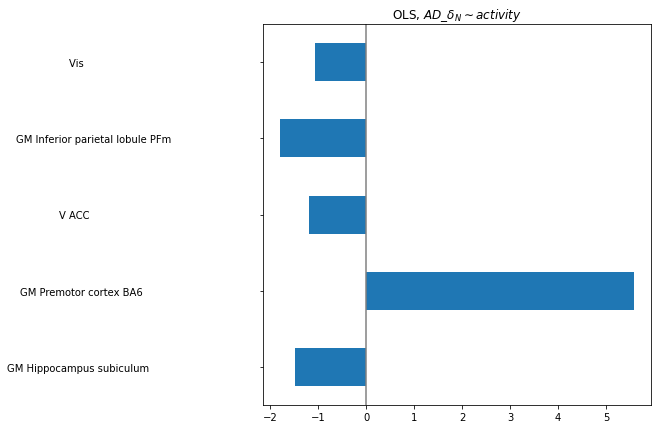

In [884]:
OLS_ADN_dif_df_top_5 = OLS_ADN_dif_df.sort_values(by=['abs_t'], ascending=False)[:5]
# sns.boxplot(x="t", y=OLS_ADN_dif_df_top_15.index, 
#             data=OLS_ADN_dif_df_top_15,
#             whis=[0, 100], width=.6, palette="vlag")


(OLS_ADN_dif_df_top_5['coef']*OLS_ADN_dif_df_top_5['std err']).\
            plot(kind="barh", figsize=(9, 7))

plt.title(r"OLS, $AD\_\delta_N \sim activity$")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)
plt.show()

In [ ]:
## medation analysis

In [ ]:
#### https://medium.com/swlh/interpreting-linear-regression-through-statsmodels-summary-4796d359035a



In [232]:
ii = nib.load(nifti_data_paths[subject][run])


In [233]:
from nilearn.plotting import plot_stat_map, show
z_slice = 21
display = plot_stat_map(ii, 
                        threshold=.03)
plt.show()

DimensionError: Input data has incompatible dimensionality: Expected dimension is 3D and you provided a 4D image. See http://nilearn.github.io/manipulating_images/input_output.html.